In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data

In [3]:
orig_df = pd.read_csv("/content/drive/MyDrive/bank_fraud/data.csv")
orig_df.head(3)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7


In [4]:
orig_df.shape

(1000000, 32)

# EDA

In [5]:
eda_df = orig_df.copy()

## Age

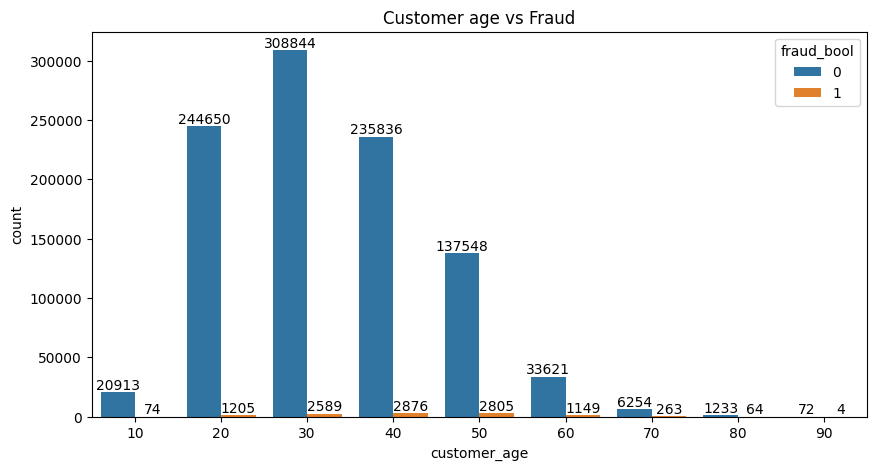

In [6]:
# customer age vs fraud
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='customer_age', data=eda_df, hue='fraud_bool')
plt.title("Customer age vs Fraud")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

## Total months

In [7]:
# check if age does not match with total months count
eda_df['total_months_count'] = eda_df['prev_address_months_count'] + eda_df['current_address_months_count']
eda_df['false_age'] = np.where(eda_df['total_months_count'] // 120 * 10 > eda_df['customer_age'], 1, 0)
eda_df['false_age'].sum()

8125

In [8]:
temp_df = eda_df[eda_df['false_age'] == 1]
temp_df.head(2)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,total_months_count,false_age
770,1,0.1,0.093374,319,109,20,0.004231,-1.417103,AC,686,...,0,INTERNET,4.819535,windows,0,1,0,7,428,1
1086,1,0.6,0.426485,304,124,20,0.012886,-1.300369,AD,1266,...,0,INTERNET,7.380458,macintosh,0,2,0,7,428,1


In [9]:
grouped_df = eda_df.groupby('customer_age').agg(false_age_count=('false_age', 'sum'), original_count=('customer_age', 'size')).reset_index()
grouped_df['fraction'] = grouped_df['false_age_count'] / grouped_df['original_count']
grouped_df

,customer_age,false_age_count,original_count,fraction
0,10,3307,20987,0.157574
1,20,4583,245855,0.018641
2,30,219,311433,0.000703
3,40,16,238712,0.000067
4,50,0,140353,0.000000
5,60,0,34770,0.000000
6,70,0,6517,0.000000
7,80,0,1297,0.000000
8,90,0,76,0.000000


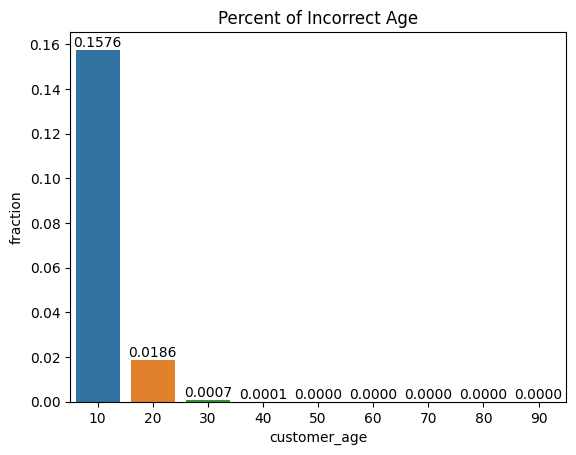

In [10]:
ax = sns.barplot(data=grouped_df, x='customer_age', y='fraction')
plt.title('Percent of Incorrect Age')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

## Payment Type

In [11]:
eda_df['payment_type'].unique()

array(['AA', 'AB', 'AC', 'AD', 'AE'], dtype=object)

In [12]:
eda_df['AA'] = np.where(eda_df['payment_type'] == 'AA', 1, 0)
eda_df['AB'] = np.where(eda_df['payment_type'] == 'AB', 1, 0)
eda_df['AC'] = np.where(eda_df['payment_type'] == 'AC', 1, 0)
eda_df['AD'] = np.where(eda_df['payment_type'] == 'AD', 1, 0)
eda_df['AE'] = np.where(eda_df['payment_type'] == 'AE', 1, 0)

In [13]:
payment_grouped = eda_df.groupby('customer_age', as_index=False)['AA', 'AB', 'AC', 'AD', 'AE'].sum()
payment_grouped

<ipython-input-13-c3cbb4b3aa0a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  payment_grouped = eda_df.groupby('customer_age', as_index=False)['AA', 'AB', 'AC', 'AD', 'AE'].sum()


,customer_age,AA,AB,AC,AD,AE
0,10,6053,5904,6286,2735,9
1,20,63437,84239,61162,36934,83
2,30,89023,108719,78433,35177,81
3,40,55557,93227,63998,25864,66
4,50,33759,59858,32886,13814,36
5,60,8199,15065,7854,3640,12
6,70,1807,2887,1240,581,2
7,80,397,614,200,86,0
8,90,17,41,12,6,0


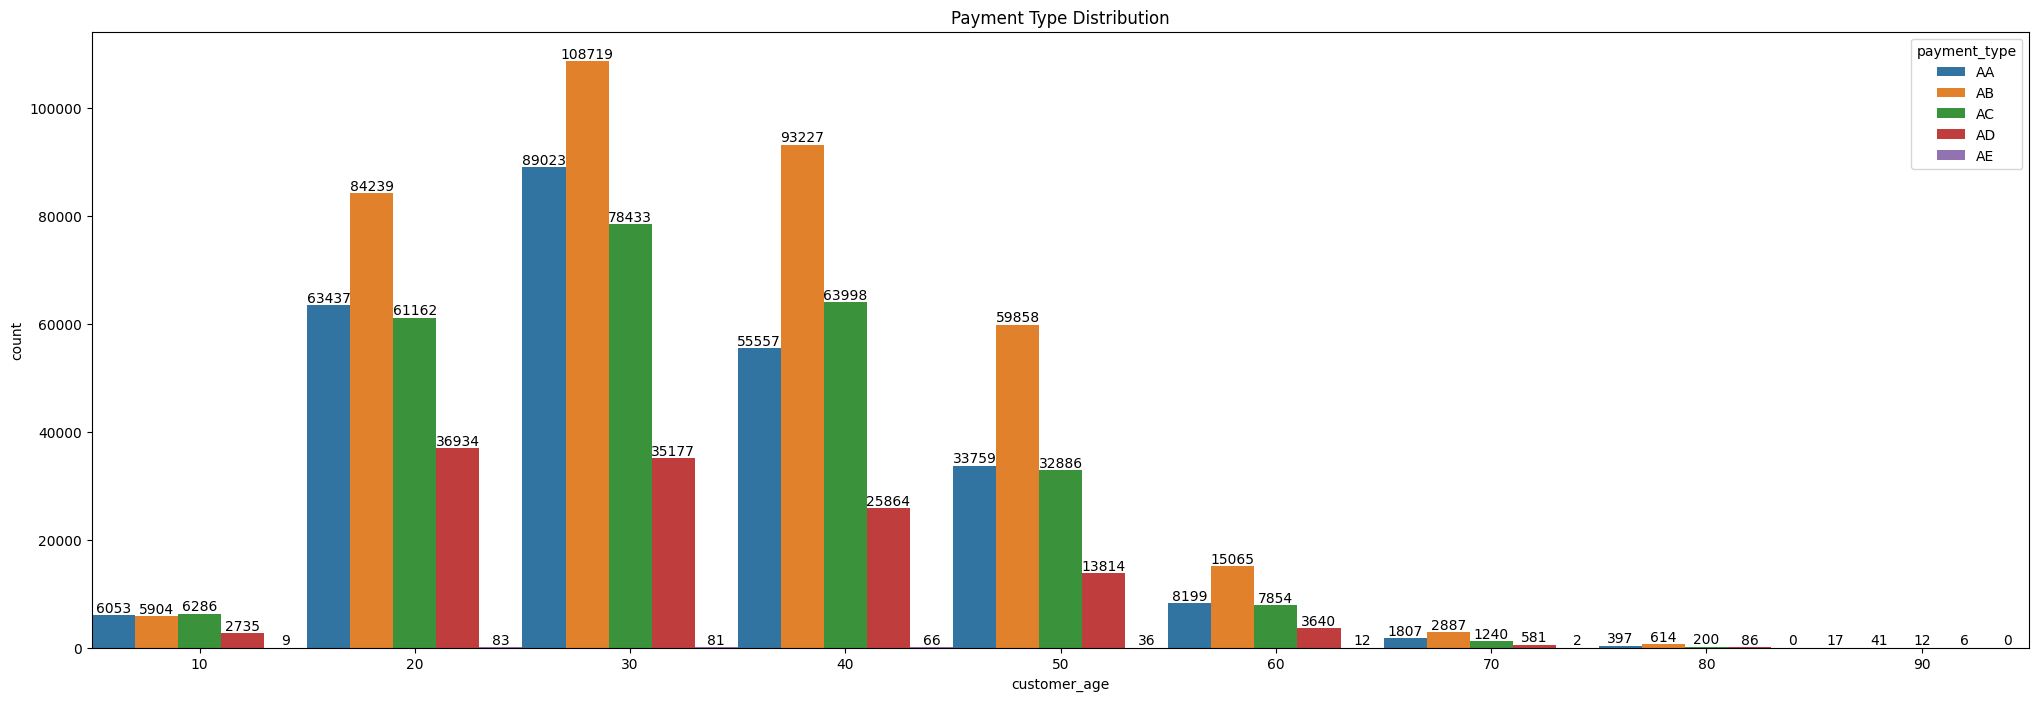

In [14]:
plt.figure(figsize=(25, 8))
ax = sns.countplot(x='customer_age', data=eda_df, hue='payment_type', width=1.0)
plt.title("Payment Type Distribution")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

## Credit Risk Score

Text(0.5, 1.0, 'Credit Risk Score')

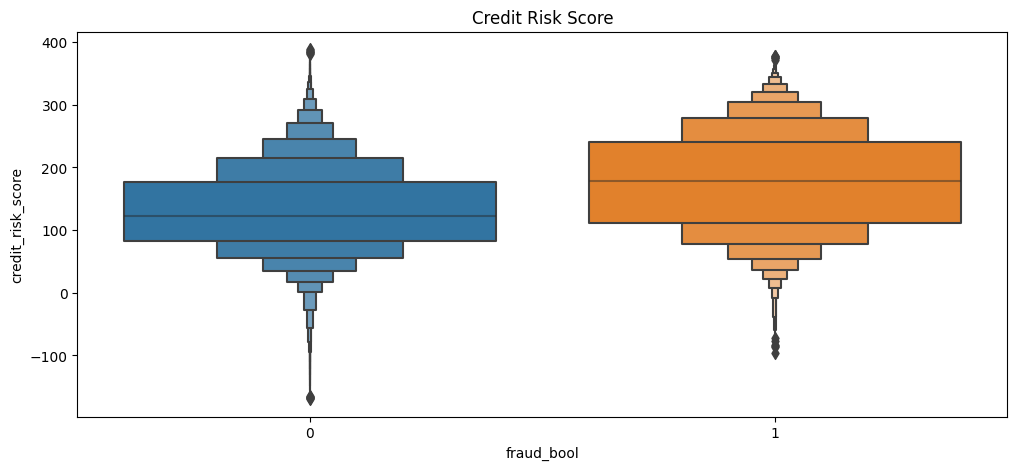

In [15]:
plt.figure(figsize=(12,5))
sns.boxenplot(data=eda_df, x='fraud_bool', y='credit_risk_score')
plt.title("Credit Risk Score")

## Month

In [16]:
eda_df['month'].unique()

array([7, 3, 2, 1, 6, 0, 5, 4])

In [17]:
nonfraud_df = eda_df[eda_df['fraud_bool'] == 0]
fraud_df = eda_df[eda_df['fraud_bool'] == 1]

In [18]:
month_dict = {0: 'Jan',
              1: 'Feb',
              2: 'Mar',
              3: 'Apr',
              4: 'May',
              5: 'Jun',
              6: 'Jul',
              7: 'Aug'}

In [19]:
fraud_month_df = fraud_df.groupby('month', as_index=False)['fraud_bool'].count()
nonfraud_month_df = nonfraud_df.groupby('month', as_index=False)['fraud_bool'].count()

month_df = pd.merge(left=fraud_month_df, right=nonfraud_month_df, on='month')
month_df['fraction'] = month_df['fraud_bool_x'] / month_df['fraud_bool_y']

month_df['month'] = month_df['month'].apply(lambda x: month_dict[x])
month_df

,month,fraud_bool_x,fraud_bool_y,fraction
0,Jan,1500,130940,0.011456
1,Feb,1198,126422,0.009476
2,Mar,1198,135781,0.008823
3,Apr,1392,149544,0.009308
4,May,1452,126239,0.011502
5,Jun,1411,117912,0.011967
6,Jul,1450,106718,0.013587
7,Aug,1428,95415,0.014966


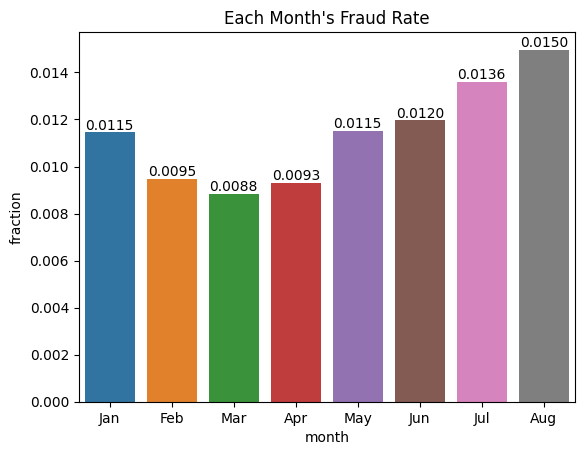

In [20]:
ax = sns.barplot(data=month_df, x='month', y='fraction')
plt.title("Each Month's Fraud Rate")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

## Velocity

Text(0.5, 1.0, 'Velocity')

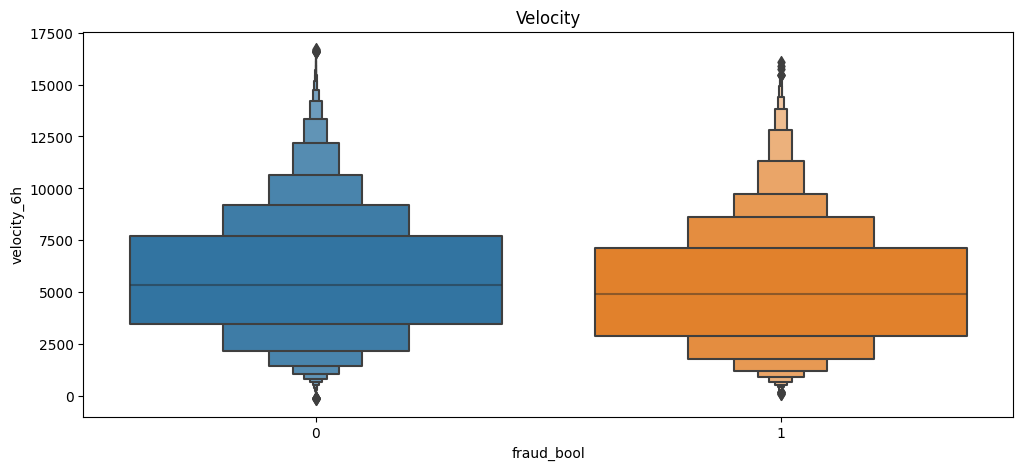

In [21]:
plt.figure(figsize=(12,5))
sns.boxenplot(data=eda_df, x='fraud_bool', y='velocity_6h')
plt.title("Velocity")

## Heatmap

<ipython-input-22-6606c5916ec5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(eda_df.corr(), cmap='coolwarm', annot=True, fmt='.2f')


<Axes: >

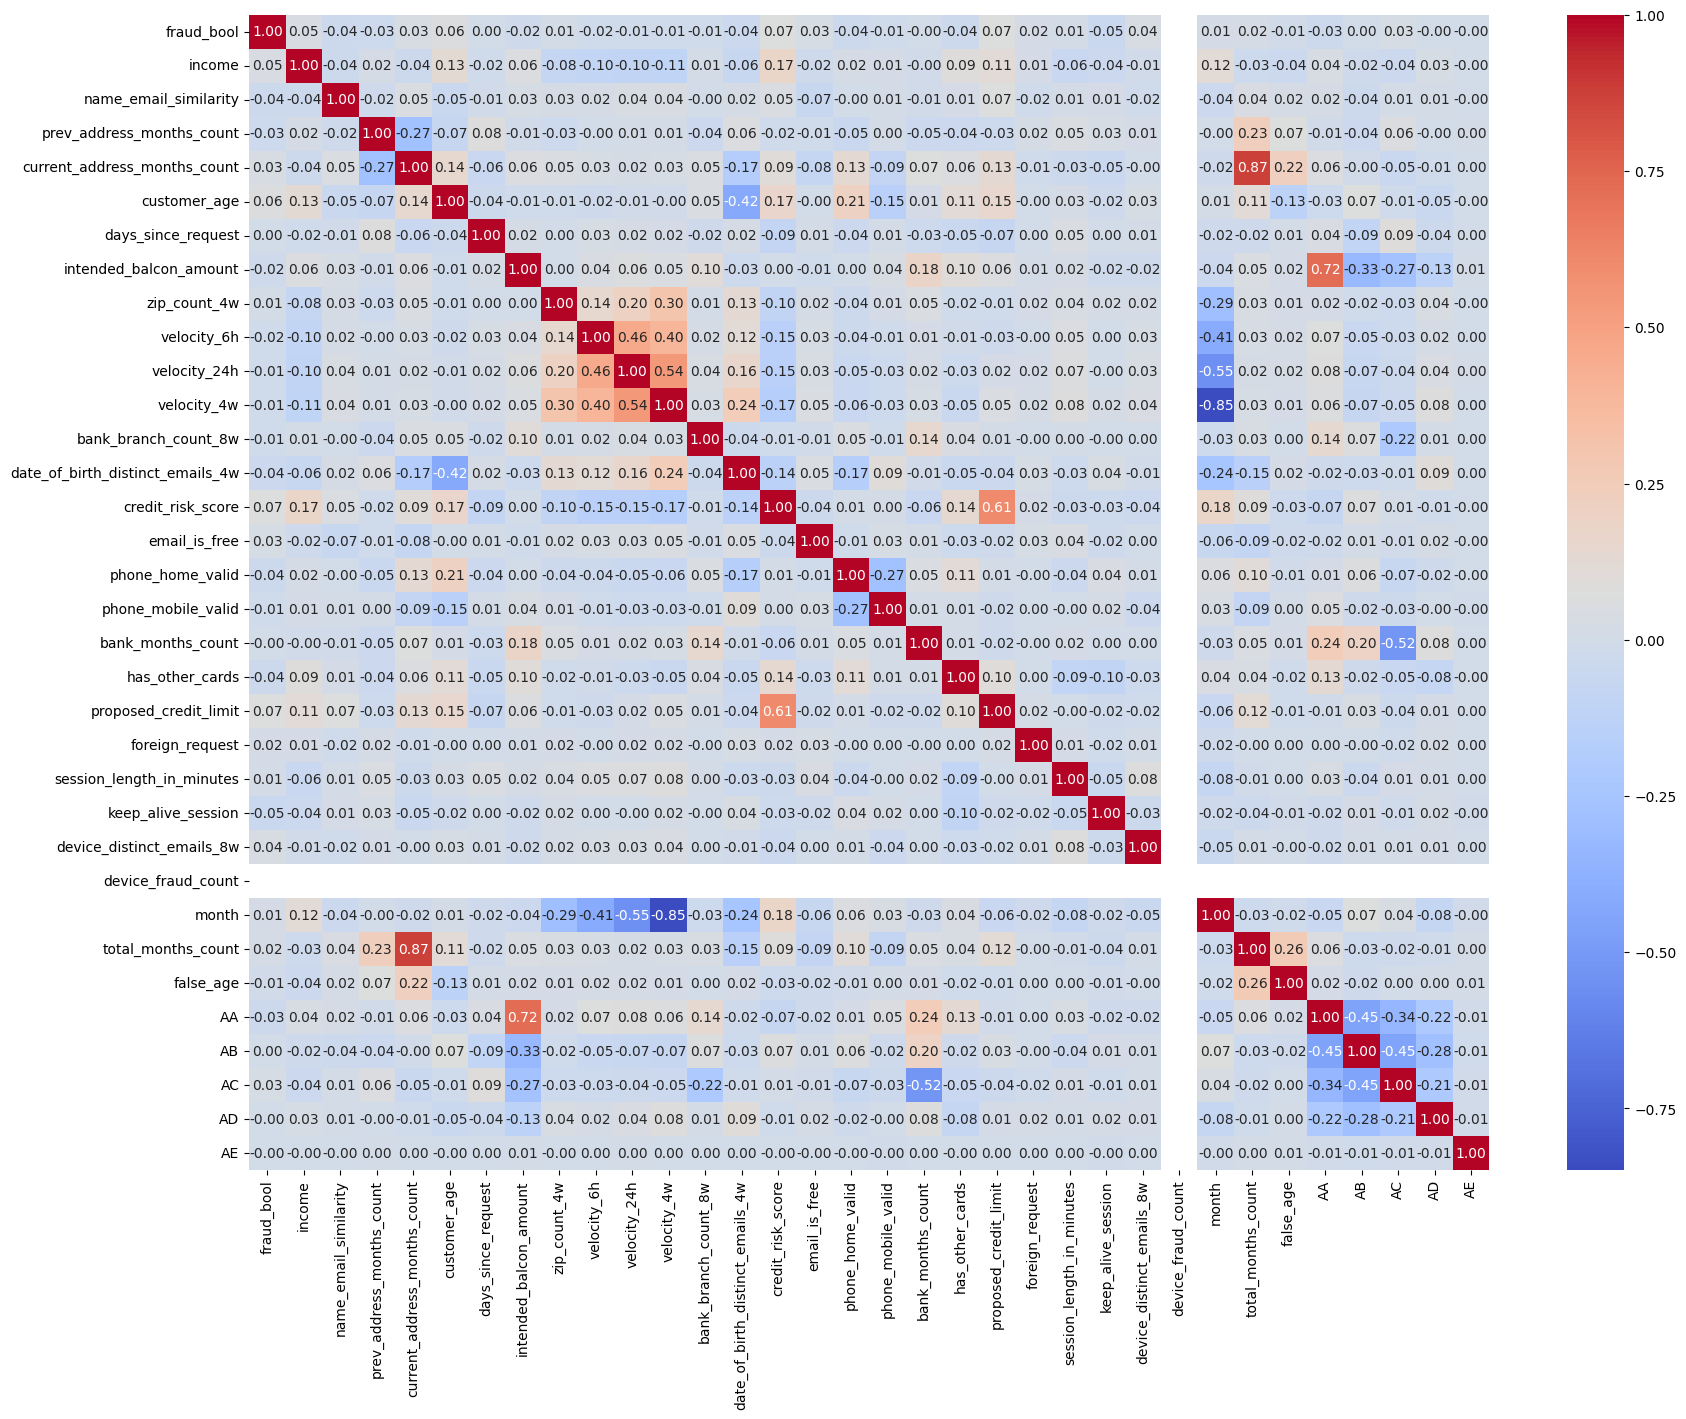

In [22]:
plt.figure(figsize=(20, 15))
sns.heatmap(eda_df.corr(), cmap='coolwarm', annot=True, fmt='.2f')

# Data Cleaning

In [23]:
clean_df = eda_df.copy()

In [24]:
for col in clean_df.columns:
  missing_count = clean_df[clean_df[col] == -1].shape[0]
  print(f"{col} is missing {missing_count} rows")

fraud_bool is missing 0 rows
income is missing 0 rows
name_email_similarity is missing 0 rows
prev_address_months_count is missing 712920 rows
current_address_months_count is missing 4254 rows
customer_age is missing 0 rows
days_since_request is missing 0 rows
intended_balcon_amount is missing 0 rows
payment_type is missing 0 rows
zip_count_4w is missing 0 rows
velocity_6h is missing 0 rows
velocity_24h is missing 0 rows
velocity_4w is missing 0 rows
bank_branch_count_8w is missing 0 rows
date_of_birth_distinct_emails_4w is missing 0 rows
employment_status is missing 0 rows
credit_risk_score is missing 488 rows
email_is_free is missing 0 rows
housing_status is missing 0 rows
phone_home_valid is missing 0 rows
phone_mobile_valid is missing 0 rows
bank_months_count is missing 253635 rows
has_other_cards is missing 0 rows
proposed_credit_limit is missing 0 rows
foreign_request is missing 0 rows
source is missing 0 rows
session_length_in_minutes is missing 2015 rows
device_os is missing 0 

In [25]:
# drop prev_address_month
clean_df.drop('prev_address_months_count', axis=1, inplace=True)

# drop AA, AB...
clean_df.drop(['AA', 'AB', 'AC', 'AD', 'AE'], axis=1, inplace=True)

In [26]:
clean_df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'total_months_count', 'false_age'],
      dtype='object')

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

features = clean_df.drop('fraud_bool', axis=1)
num_cols = ['income', 'name_email_similarity', 'current_address_months_count', 'customer_age', 
            'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 
            'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
            'session_length_in_minutes', 'total_months_count']
cat_cols = ['payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 
            'has_other_cards', 'foreign_request', 'source', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 
            'device_fraud_count', 'month', 'false_age']

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

X = full_pipe.fit_transform(features)
y = clean_df[['fraud_bool']]

# Modeling

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

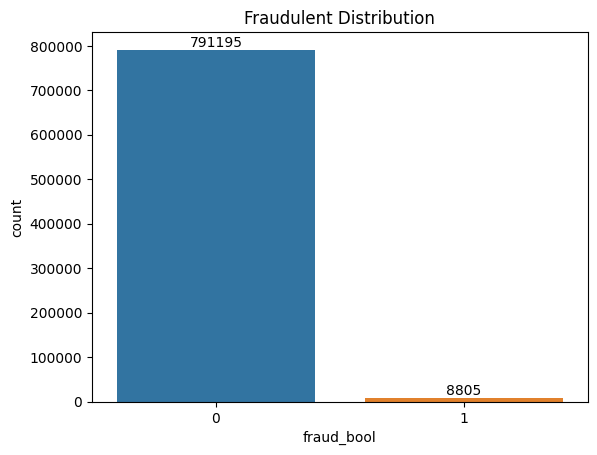

In [29]:
ax = sns.countplot(data=y_train, x='fraud_bool')
plt.title('Fraudulent Distribution')

for i in ax.containers:
  ax.bar_label(i)

## Oversampling

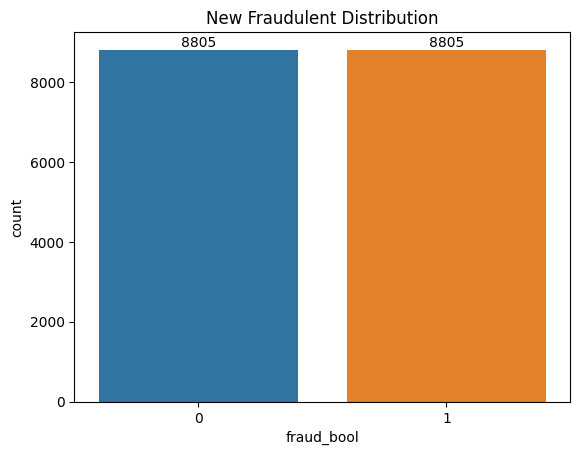

In [30]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
under_X_train, under_y_train = rus.fit_resample(X_train, y_train)


ax = sns.countplot(data=under_y_train, x='fraud_bool')
plt.title('New Fraudulent Distribution')

for i in ax.containers:
  ax.bar_label(i)

## Classification Metrix

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

def calc_acc(y_pred, y_actual):
  # classification report
  print(classification_report(y_actual, y_pred))

  # draw confusion matrix
  cm = confusion_matrix(y_actual, y_pred)

  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  tick_labels = np.unique(np.concatenate((y_actual, y_pred)))
  plt.xticks(np.arange(len(tick_labels))+0.5, tick_labels)
  plt.yticks(np.arange(len(tick_labels))+0.5, tick_labels)
  plt.show()

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()

log_model = log.fit(under_X_train, under_y_train)
y_pred = log_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      0.80      0.89    197776
           1       0.04      0.80      0.08      2224

    accuracy                           0.80    200000
   macro avg       0.52      0.80      0.49    200000
weighted avg       0.99      0.80      0.88    200000



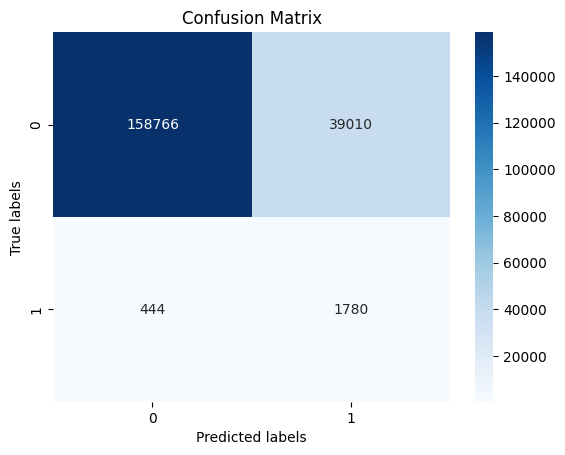

In [33]:
calc_acc(y_pred, y_test['fraud_bool'])

## Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced', n_estimators=120, max_depth=30, random_state=42)

rfc_model = rfc.fit(under_X_train, under_y_train)
y_pred = rfc_model.predict(X_test)

<ipython-input-34-5a01425db18f>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_model = rfc.fit(under_X_train, under_y_train)


              precision    recall  f1-score   support

           0       1.00      0.81      0.89    197776
           1       0.04      0.79      0.08      2224

    accuracy                           0.81    200000
   macro avg       0.52      0.80      0.49    200000
weighted avg       0.99      0.81      0.88    200000



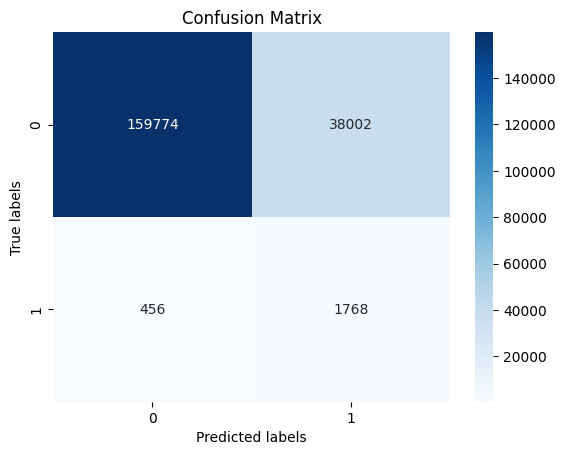

In [35]:
calc_acc(y_pred, y_test['fraud_bool'])

# PCA

In [36]:
# running PCA might bring up accuracy bc it removes correlated features
from sklearn.decomposition import PCA

In [37]:
pca = PCA()
pca.fit(under_X_train)

explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

Text(0.5, 1.0, 'Cumulative Explained Variance Ratio vs Number of Components')

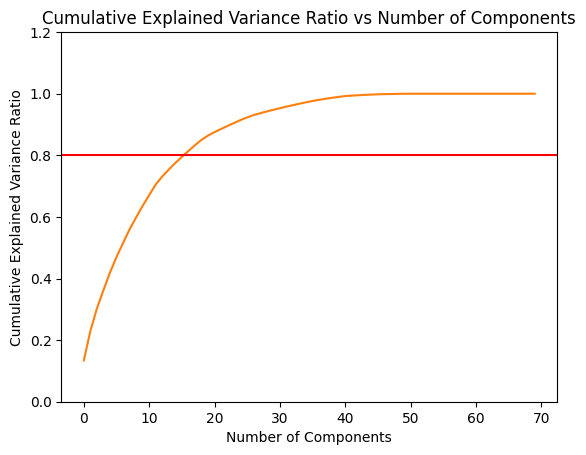

In [38]:
plt.plot(1, len(cum_evr) + 1, cum_evr)
plt.axhline(y=0.8, color='r', linestyle='-')
plt.ylim(0, 1.2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Components')

In [39]:
better_pca = PCA(n_components=15)
better_pca.fit(under_X_train)

X_train_pca = better_pca.transform(under_X_train)
X_test_pca = better_pca.transform(X_test)

## Log Reg 2.0

In [40]:
X_train_pca.shape

(17610, 15)

In [41]:
pca_log_model = log.fit(X_train_pca, under_y_train)
y_pred = pca_log_model.predict(X_test_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.76      0.86    197776
           1       0.03      0.74      0.06      2224

    accuracy                           0.76    200000
   macro avg       0.51      0.75      0.46    200000
weighted avg       0.99      0.76      0.85    200000



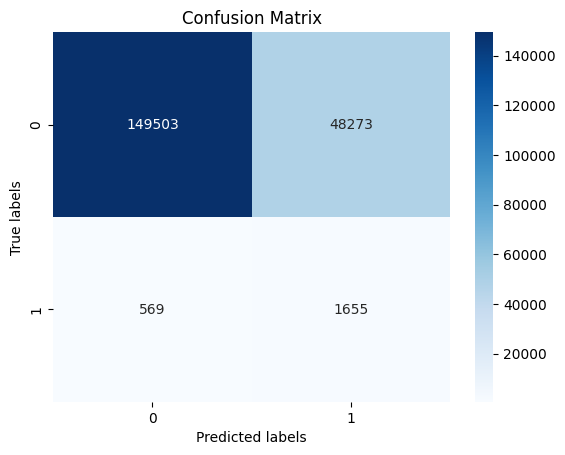

In [42]:
calc_acc(y_pred, y_test['fraud_bool'])

## Random Forest 2.0

In [43]:
rfc_model = rfc.fit(X_train_pca, under_y_train)
y_pred = rfc_model.predict(X_test_pca)

<ipython-input-43-cf93e94c832d>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_model = rfc.fit(X_train_pca, under_y_train)


              precision    recall  f1-score   support

           0       1.00      0.77      0.87    197776
           1       0.03      0.73      0.07      2224

    accuracy                           0.77    200000
   macro avg       0.52      0.75      0.47    200000
weighted avg       0.99      0.77      0.86    200000



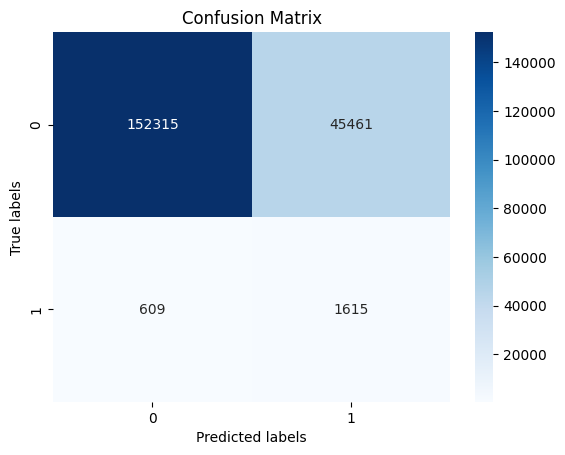

In [44]:
calc_acc(y_pred, y_test['fraud_bool'])

# SVM

In [45]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=5, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X_train_pca, under_y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, degree=5, kernel='poly'))])

              precision    recall  f1-score   support

           0       1.00      0.72      0.84    197776
           1       0.03      0.74      0.06      2224

    accuracy                           0.72    200000
   macro avg       0.51      0.73      0.45    200000
weighted avg       0.99      0.72      0.83    200000



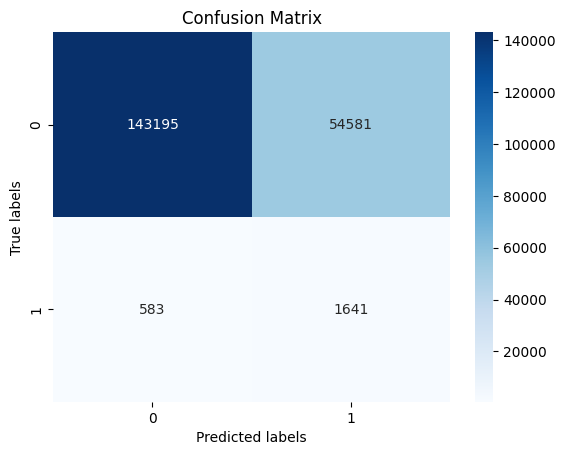

In [46]:
y_pred = poly_kernel_svm_clf.predict(X_test_pca)
calc_acc(y_pred, y_test['fraud_bool'])

# Voting Classifier

# Visualization with t-SNE

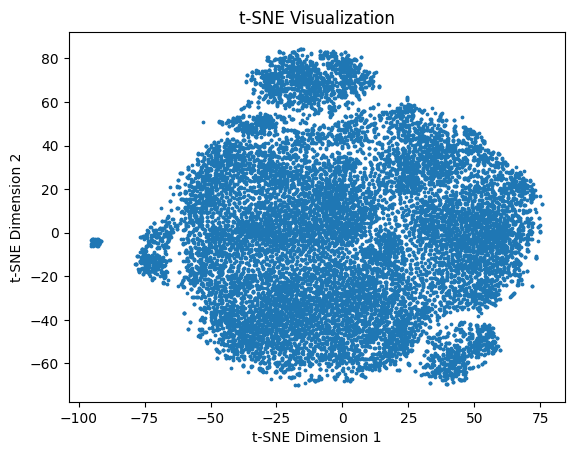

In [49]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(under_X_train)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=3)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()